In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [5]:
Smarket = load_data('Smarket')

In [6]:
Smarket.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


In [8]:
# pass the numeric_only argument to avoid getting the error for categorical columns
Smarket.corr(numeric_only = True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


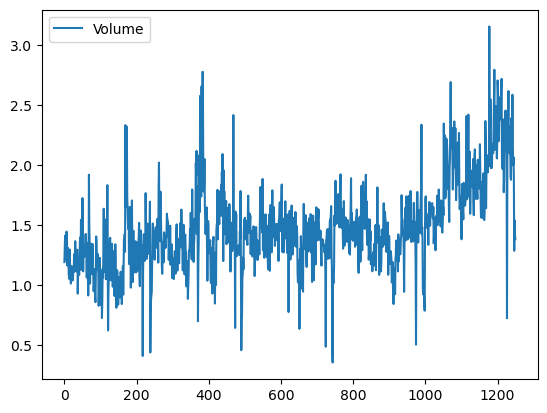

In [9]:
Smarket.plot(y = 'Volume');

In [ ]:
"""
Logistic regression
"""

In [14]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'

# pass the family argument as binomial. else some other 
# the default family is Gaussian

glm = sm.GLM(y, X, family = sm.families.Binomial())

# else we can execute 
#glm = sm.Logit(y,X)

results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [19]:
probs = results.predict()

In [20]:
Smarket.shape

(1250, 9)

In [21]:
labels = np.array(['Down'] * 1250)
labels[probs > 0.5] = 'Up'

In [24]:
# confusion_table - ISLP package function similar to sklearn.metrics
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [27]:
model_accuracy = (145 + 507) / 1250
model_accuracy

0.5216

In [31]:
train = (Smarket.Year < 2005)

Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
print(Smarket_train.shape, Smarket.shape)

(998, 9) (1250, 9)


In [32]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train, family = sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog = X_test)

In [33]:
D = Smarket.Direction
Label_train, Label_test = D.loc[train], D.loc[~train]

In [34]:
labels = np.array(['Down'] * 252)
labels[probs > 0.5] = 'Up'
confusion_table(labels, Label_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [36]:
np.mean(labels == Label_test), np.mean(labels != Label_test)

(np.float64(0.4801587301587302), np.float64(0.5198412698412699))

In [38]:
# use only the 2 lowest p value indicators
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train, X_train, family = sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog = X_test)
labels = np.array(['Down'] * 252)
labels[probs > 0.5] = 'Up'
confusion_table(labels, Label_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [39]:
newdata = pd.DataFrame({'Lag1':[1.2, 1.5],
                        'Lag2':[1.1, -0.8]});
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

In [ ]:
"""
Linear Discriminant Analysis (LDA)
"""

In [43]:
# store the covariance matrix, in case we need to fetch it and analyse
lda = LDA( store_covariance = True )

# we need to drop the intercept added in the dataset. because the LDA adds the intercept itself
X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]]

# label as available in the original dataset itself can be used to train LDA
lda.fit(X_train, Label_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [45]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [44]:
# means of the coefficients within each class
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [ ]:
"""
output should be read like this


| Class   | Feature 1 mean | Feature 2 mean |
| ------- | -------------- | -------------- |
| Class 0 | 0.0428         | 0.0339         |
| Class 1 | −0.0395        | −0.0313        |

"""

In [46]:
# the class probability from the whole dataset calculated by lda
lda.priors_

array([0.49198397, 0.50801603])

In [80]:
# common covariance matrix for all the classes
lda.covariance_

array([[ 1.50886781, -0.03340234],
       [-0.03340234,  1.5095363 ]])

In [47]:
lda.scalings_
# detailed explanation about this will be included in the README section of this chapter

array([[-0.64201904],
       [-0.51352928]])

In [ ]:
"""
from text book - 
These values provide the linear combination of Lag1 and Lag2 that are used to form the LDA decision rule. 
If $-0.64\times Lag1 - 0.51 \times Lag2 $ is large, then the LDA classifier will predict a market increase, 
and if it is small, then the LDA classifier will predict a market decline.
"""

In [66]:
lda_pred = lda.predict(X_test)

In [67]:
confusion_table(lda_pred, Label_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [74]:
pd.concat(
    [X_test.reset_index(drop=True),
     Label_test.reset_index(drop=True),
     pd.Series(lda_pred, name="Pred")],
    axis=1
).head(10)

,Lag1,Lag2,Direction,Pred
0,-0.134,0.008,Down,Up
1,-0.812,-0.134,Down,Up
2,-1.167,-0.812,Down,Up
3,-0.363,-1.167,Up,Up
4,0.351,-0.363,Down,Up
5,-0.143,0.351,Up,Up
6,0.342,-0.143,Down,Up
7,-0.610,0.342,Up,Up
8,0.398,-0.610,Down,Up
9,-0.863,0.398,Up,Up


In [75]:
# check the rows on which the prob of market going Down is more than 90%
np.sum(lda_prob[:,0] > 0.9)

np.int64(0)

In [ ]:
"""
Quadratic Discriminant Analysis (QDA)
"""

In [77]:
qda = QDA(store_covariance=True)
qda.fit(X_train, Label_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [78]:
qda.means_, qda.priors_
# means and priors are same for the classes as calculated by LDA

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [79]:
# one covariance matrix per class
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [81]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, Label_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [83]:
np.mean(qda_pred == Label_test)

np.float64(0.5992063492063492)

In [85]:
151/252

0.5992063492063492

In [ ]:
"""
Naive Bayes
"""